In [17]:
import pandas as pd

df = pd.read_csv('./data/cabaventa.csv')
df.shape

(183810, 27)

## Limpieza Texto y Columnas

In [18]:
from cleaning import CleaningData
#instanciamos Cleaning Data con df

cleaned = CleaningData(data=df)

In [19]:
#Quitamos columnas 
cols_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', # todos son 'Argentina'
                'l2', # todos son "Capital Federal"
                'ad_type', #todas las filas iguales 
                'l4', #todas las filas nulas preferible el dato de lat y long
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
               ]
data = cleaned.drop_columns(columns=cols_to_drop)
data.shape

Cleaning columns with no valuable information...



(183810, 17)

In [10]:
#Limpieza title
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="title", params=params)
data.shape

(183810, 18)

In [11]:
#Limpieza description
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="description", params=params)
data.shape

(183810, 19)

In [20]:
#Limpieza texto de l3
params = {'lowering':False,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="l3", params=params)
data.shape

(183810, 18)

# Imputación de barrio correcto

In [14]:
#Dado que queremos realizar predicciones en base a la ubicación, necesitamos garantizar
# la calidad del dato de geolocalización. Por ende no queremos re-imputar datos que en la fuente
# contengan mal el dato de localización. 

lat_ok = (data.lat>-35)|(data.lat<-34) #Lat debe ser un valor (-35:-34) --> CABA
lon_ok = (data.lon>-59)|(data.lon<-58) #Lon debe ser un valor (-59:-58) --> CABA
data = data[lat_ok | lon_ok]
data.shape

(172362, 20)

In [19]:
def geoRadios(geojson_url, obj_returned = "dict"): 

    url = geojson_url
    r = requests.get(url)
    js = r.json()

    keys = list(js['features'][0]['properties'].keys())[1:]
    geoBarrios = pd.DataFrame()
    for i in range(len(js['features'])): 
        properties = js['features'][i]['properties']
        datos = {k:properties[k] for k in keys}
        datos['coordinates'] = js['features'][i]['geometry']['coordinates']
        df_temp = pd.DataFrame(datos, index=[i])
        geoBarrios = geoBarrios.append(df_temp, ignore_index=True)

    geoBarrios.columns = [x.lower() for x in geoBarrios.columns]
    geoBarrios['barrio'] = geoBarrios['barrio'].apply(lambda x: x.lower())
    
    if obj_returned == 'dataframe': 
        return geoBarrios
    elif obj_returned == 'dict': 
        return geoBarrios[['barrio','coordinates']].set_index('barrio').to_dict()['coordinates']
    else: 
        print("Define returned object type")

In [27]:
import requests
import numpy as np
import string
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


url_radios = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/informacion-censal-por-radio/caba_radios_censales.geojson"
#geoRadios(geojson_url=url_radios)
#url = geojson_url
r = requests.get(url_radios)
js = r.json()
#keys = list(js['features'][0]['properties'].keys())[1:]
js['features'][0]['properties']

{'WKT': 'MULTIPOLYGON (((-58.372489764082 -34.5915465708107,-58.3726119195164 -34.5915127160525,-58.372623878948 -34.5916825496944,-58.3736907626257 -34.5911648295757,-58.3737502692038 -34.5911535188844,-58.3739745417299 -34.5911309739871,-58.3741530451682 -34.59111218017,-58.374001304695 -34.5909456128529,-58.3735516937449 -34.5904958460311,-58.3737909069729 -34.5903576900843,-58.3734976811433 -34.5899830951108,-58.3726893235965 -34.5889914059596,-58.3772513488885 -34.5864186669828,-58.377214745405 -34.5862397609208,-58.3771413848714 -34.5860322363801,-58.3770537566925 -34.5858590053353,-58.3770532176401 -34.585811871026,-58.3769275628093 -34.585686321587,-58.3766327692747 -34.5856386794102,-58.3755367870144 -34.5843118246194,-58.3756481811195 -34.5842222129065,-58.3757794905326 -34.5841916226563,-58.3764362898041 -34.5837931987454,-58.3772901033118 -34.5832910562935,-58.3767105119888 -34.5825891236038,-58.3766245693899 -34.5824729278448,-58.3765024522448 -34.5822967657414,-58.3763803

In [22]:
import requests
import pandas as pd
import numpy as np
import string
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from geoBarrios import *

geoBarrios = geoBarrios() #devuelve un dict (datos GCBA)

from tqdm import tqdm
barrio_imput = []
for tup in tqdm([(nbhd, lon,lat) for nbhd, lon, lat in zip(df.l3, df.lon,df.lat)]):
    barrio = coord_to_nbhd(coord = tup[1:],est_nbhd=tup[0], polygons_dict=geoBarrios) #usando librería shapley
    barrio_imput.append(barrio)

cleaned.data['barrio_ok'] = barrio_imput

ModuleNotFoundError: No module named 'shapely'

(array([1.7236e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.39116561e-101, 3.23019767e-007, 6.46039535e-007, 9.69059302e-007,
        1.29207907e-006, 1.61509884e-006, 1.93811860e-006, 2.26113837e-006,
        2.58415814e-006, 2.90717791e-006, 3.23019767e-006]),
 <BarContainer object of 10 artists>)

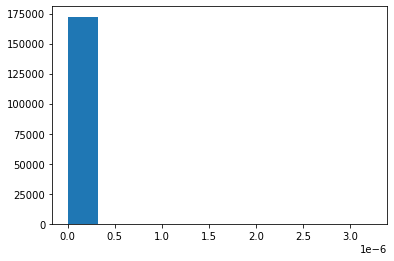

In [27]:
import matplotlib.pyplot as plt
plt.hist(10**cleaned.data.lon)

In [ ]:
cleaned.data.loc[(cleaned.data.barrio_ok!=cleaned.data.l3.cleaned), ["lon","lat",]]

Casos: 

1. ($Barrio$, $None$) --> No existe coordenada en CABA
2. ($None$, $Barrio$) --> Recupera dato
3. ($None$, $None$) --> No modifica
4. ($Barrio_a$, $Barrio_b$) --> Corrige
5. ($Barrio_a$, $Barrio_a$) --> Ratifica

In [18]:
cleaned.data['result_barrio'] = np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()),1,
                                            np.where((cleaned.data.l3_cleaned.isna()) & (cleaned.data.barrio_ok.isna()==False),2,
                                                    np.where((cleaned.data.l3_cleaned.isna()) & (cleaned.data.barrio_ok.isna()),3,
                                                             np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()==False) &
                                         (cleaned.data.l3_cleaned != cleaned.data.barrio_ok),4,
                                                                     np.where((cleaned.data.l3_cleaned.isna()==False) & (cleaned.data.barrio_ok.isna()==False) &
                                         (cleaned.data.l3_cleaned == cleaned.data.barrio_ok),5,6)))))

100*cleaned.data.result_barrio.value_counts(normalize=True)

5    68.498994
1    20.587563
4     9.908601
3     0.956422
2     0.048420
Name: result_barrio, dtype: float64